In [1]:
import pandas as pd
import numpy as np
import sqlite3
import os.path
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import pickle as pk
import collections 

pd.set_option("display.max_rows",15)
%matplotlib inline

In [2]:
conn = create_engine('sqlite:///../dataset/ijcai_cff_2017.db')

In [3]:
no_of_shops = 2000
shops = pd.DataFrame({"shop_id":np.arange(start=1, stop = (no_of_shops+1))})
shops.to_sql("shops", index = False, con = conn, if_exists='replace')

In [4]:
train_data = []
train_data_raw = pd.read_sql_query("select d.shop_id, "
                                   "d.total_view + d.total_pay as input_foot_traffic "
                                   "from train_data d "
                                   #"where shop_id = {}".format(i) 
                                   ,con = conn)


In [5]:
shape_of_network = [2,128,1]
num_of_layers_dense = 2

In [6]:
train_data = train_data_raw.dropna(how = "any")
train_data = train_data.set_index("shop_id")
train_data.loc[1:10]

,input_foot_traffic
shop_id,
1,178.0
1,233.0
1,250.0
1,234.0
1,230.0
1,237.0
1,191.0
...,...
10,61.0


In [7]:
train_data_group = train_data.groupby("shop_id", level = 0)
train_data_group.count().max()

input_foot_traffic    130
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

impute_x = Imputer()
impute_y = Imputer()

scaler = StandardScaler()

def scale(x):
    return scaler.fit_transform(x)

def reverse_scale(x):
    return scaler.inverse_transform(x)

def split(x,y_):
    x_train, x_valid, y_train, y_valid = train_test_split(
    x, y_ , test_size=0.2, random_state=42)
    
    x_valid, x_test, y_valid, y_test = train_test_split(
    x_valid, y_valid , test_size=0.5, random_state=42)
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test 

In [9]:
shop_id = 1
train = train_data.loc[shop_id] # Select which shop
shape = train.values.shape
train_scaled = scale(train.values.ravel().reshape(-1, 1)).reshape(shape)
train_scaled.shape

(130, 1)

In [10]:
skip = train_scaled.shape[0] % (shape_of_network[0] + shape_of_network[-1] ) #
if skip is not 0:
    train_trim = train_scaled[skip:,]
train_trim.shape

(129, 1)

In [11]:
step = shape_of_network[0]
x_arr = []
y_arr = []
for i in range(0, train_trim.shape[0]-skip, step):
    x_arr.append(train_trim[i:i+shape_of_network[0]].flatten())
    y_arr.append(train_trim[i+shape_of_network[0]].flatten())

x_arr = np.array(x_arr)
y_arr = np.array(y_arr)

print("x: {}".format(x_arr))
print("y: {}".format(y_arr))

x: [[ -9.07830418e-01  -5.92125426e-01]
 [ -8.89259536e-01  -9.63543063e-01]
 [ -8.33546890e-01  -1.68780746e+00]
 [ -5.17841898e-01  -3.87845725e-01]
 [ -2.57849552e-01  -1.18639365e+00]
 [ -1.07496835e+00  -4.06416607e-01]
 [ -2.76420434e-01  -7.22121599e-01]
 [ -1.83566025e-01   7.07836305e-01]
 [ -3.69274843e-01  -1.27853379e-01]
 [  2.80706022e-01  -7.22121599e-01]
 [ -1.14925188e+00  -8.33546890e-01]
 [ -3.13562198e-01   1.13568085e-01]
 [ -9.07830418e-01  -4.24987489e-01]
 [ -2.94991316e-01  -6.29267190e-01]
 [ -3.69274843e-01  -2.20707788e-01]
 [ -4.80700135e-01  -1.05639747e+00]
 [ -1.64280878e-02  -8.52117772e-01]
 [  1.50709849e-01  -3.49989697e-02]
 [ -1.05639747e+00  -3.32133080e-01]
 [ -9.07830418e-01   2.63920802e+00]
 [  2.54635361e+00   4.77485944e+00]
 [ -2.76420434e-01   2.14279406e-03]
 [  3.73560432e-01   1.13496659e+00]
 [ -3.13562198e-01   3.92845578e-02]
 [ -1.64995143e-01   2.24993377e-01]
 [  5.78554397e-02  -4.62129253e-01]
 [ -1.83566025e-01  -2.76420434e-01

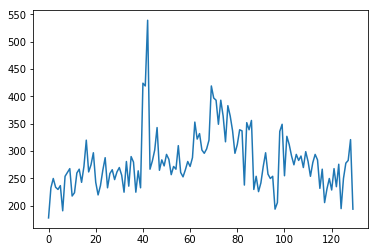

In [12]:
plt.plot(train.values.ravel())

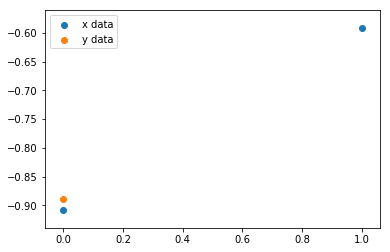

In [13]:
plt.scatter([range(x_arr[0].ravel().shape[0])],x_arr[0].ravel(), label = "x data")
plt.scatter([range(y_arr[0].ravel().shape[0])], y_arr[0].ravel(), label = "y data")
plt.legend()

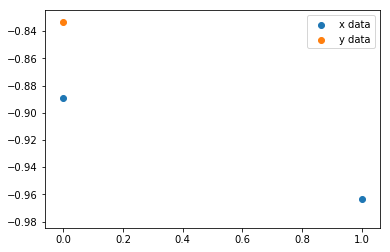

In [14]:
plt.scatter([range(x_arr[1].ravel().shape[0])],x_arr[1].ravel(), label = "x data")
plt.scatter([range(y_arr[1].ravel().shape[0])], y_arr[1].ravel(), label = "y data")
plt.legend()

In [15]:
print("x shape {}".format(x_arr.shape))
print("y shape {}".format(y_arr.shape))
x_train, x_valid, x_test, y_train, y_valid, y_test = split(x_arr, y_arr)

x shape (64, 2)
y shape (64, 1)


In [16]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(51, 2)
(6, 2)
(7, 2)
(51, 1)
(6, 1)
(7, 1)


In [17]:
import pickle
data  = {
    "x_train":x_train,
    "x_valid":x_valid,
    "x_test":x_test,
    "y_train":y_train,
    "y_valid":y_valid,
    "y_test":y_test,
    
}

fo = open("x_y_input_traffic_shop_id_{}.pkl".format(shop_id), "wb")
pickle.dump(data,fo)
fo.close()

#.to_pickle("x_y_input_traffic_shop_id_{}.pkl".format(shop_id))